# Notebook 2: superconductivity dataset

*This notebook contains the script for computation and for the visualisation of Figure 5 (section 5.2.2).*

In [1]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
import pandas as pd
dataframe = pd.read_csv("data.csv") 
data = pd.DataFrame.as_matrix(dataframe) # Deprecated!
#data = dataframe.to_numpy()

/Users/audesportisse/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
X = data[:,0:81] 
y = data[:,81] 

from sklearn.preprocessing import scale
X = scale(X)
y = scale(y)

n,d = X.shape

In [4]:
X_reg=np.concatenate((X, np.ones((n,1))), axis=1)
beta_reg=(np.linalg.pinv(X_reg.T.dot(X_reg)).dot(X_reg.T)).dot(y)

In [6]:
from sgd_lin_na import *

In [8]:
%run 'EMcodeRtoPython.py'
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sgd_lin_na import *
from sklearn.linear_model import LinearRegression, Ridge
from  sklearn.linear_model import RidgeCV

list_sgd_av = []
list_sgd_av_comp = []
list_em = []
list_mean = []

list_sgd_av_st = []
list_sgd_av_comp_st = []
list_mean_st = []

Nbsim = 6
for seed in range(0,Nbsim):
    print(seed)
    
    ## Split Train Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    n_test = X_test.shape[0]
    n_train = X_train.shape[0]
    
    #MCAR (heterogenous)
    p = np.random.uniform(low=0.7,high=1,size=d)
    D_init_train = np.zeros((n_train,d))
    for j in range(0,d):
           D_init_train[:,j] = np.random.binomial(n=1, p=p[j], size= n_train)

    X_NA_train = X_train*D_init_train
    index=D_init_train.sum(axis=1)!=0
    X_NA_train=X_NA_train[index,]
    X_train = X_train[index,]
    y_train = y_train[index,]
    D_train = D_init_train[index,]
    n_train,d = X_train.shape
    
    clf = RidgeCV(alphas=np.linspace(0.001,1,1000)).fit(X_train, y_train)
    alpha=clf.alpha_
    
    ## SGD
    X_sgd_train = np.concatenate((X_train, np.ones((n_train,1))), axis=1)
    X_NA_sgd_train = np.concatenate((X_NA_train, np.ones((n_train,1))), axis=1)
    D_sgd_train = np.concatenate((D_train, np.ones((n_train,1))), axis=1)
    d_sgd = X_NA_sgd_train.shape[1]
    p_estim = np.sum(D_sgd_train,axis=0)/D_sgd_train.shape[0]
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_NA_sgd_train,
                                     D=D_sgd_train,
                                     y=y_train,
                                     p=p_estim,
                                     beta_true=beta_reg,
                                     strength=alpha)
    
    L = model.lip_max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av = inspector(model,verbose=False)
    beta_sgd_av_train = avsgdNA(model, 
                                beta0,
                                nepoch,
                                step=step,
                                verbose=False,
                                callback=callback_sgd_av)

    
    ## AVSGD complete case
    #model = LinRegNA_oracle(X_comp=X_sgd_train,X=X_sgd_train,D=D_sgd_train,y=y_train,p=1,beta_true=beta_reg,strength=alpha)
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_sgd_train,
                                     D=np.ones(X_sgd_train.shape),
                                     y=y_train,
                                     p=p_estim,
                                     beta_true=beta_reg,
                                     strength=alpha)
    L = model.lip_max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av_comp = inspector(model,verbose=False)
    beta_sgd_av_train_comp = avsgd(model,
                                   beta0,
                                   nepoch,
                                   step,
                                   verbose=False,
                                   callback=callback_sgd_av_comp)
    
    
    ## Mean + AVSGD
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_NA_train_imp = imp.fit_transform(X_NA_sgd_train)
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_NA_train_imp,
                                     D=D_sgd_train,
                                     y=y_train,
                                     p=1,
                                     beta_true=beta_reg,
                                     strength=alpha)
    L = ((X_NA_train_imp**2).sum(axis=1)).max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av_mean = inspector(model,verbose=False)
    beta_sgd_av_train_mean = avsgd(model,
                                   beta0,
                                   nepoch,
                                   step,
                                   verbose=False,
                                   callback=callback_sgd_av_mean)
    
    
    ### Without regularization
    alpha=0
    
    
    ## SGD
    X_sgd_train=np.concatenate((X_train, np.ones((n_train,1))), axis=1)
    X_NA_sgd_train=np.concatenate((X_NA_train, np.ones((n_train,1))), axis=1)
    D_sgd_train =np.concatenate((D_train, np.ones((n_train,1))), axis=1)
    d_sgd = X_NA_sgd_train.shape[1]
    p_estim = np.sum(D_sgd_train,axis=0)/D_sgd_train.shape[0]
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_NA_sgd_train,
                                     D=D_sgd_train,
                                     y=y_train,
                                     p=p_estim,
                                     beta_true=beta_reg,
                                     strength=alpha)  
    L = model.lip_max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av_st = inspector(model,verbose=False)
    beta_sgd_av_train_st = avsgdNA(model,
                                   beta0,
                                   nepoch,
                                   step,
                                   verbose=False,
                                   callback=callback_sgd_av_st)
    
    
    ## EM
    modelEM = EMLR()
    D_EM_train = np.ones((n_train,d))
    for i in range(0,n_train):
        for j in range(0,d):
            if (D_train[i,j]==0):
                D_EM_train[i,j]=np.nan
            else:
                D_EM_train[i,j]=D_train[i,j]
    X_NA_EM_train = X_train*D_EM_train
    modelEM.fit(X=X_NA_EM_train,y=y_train)
    beta0_em_train, beta_em_train = modelEM.get_beta(X_NA_EM_train)
    
    
    ## AVSGD complete case
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_sgd_train,
                                     D=D_sgd_train,
                                     y=y_train,
                                     p=1,
                                     beta_true=beta_reg,
                                     strength=alpha)
    L = model.lip_max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av_comp_st = inspector(model,verbose=False)
    beta_sgd_av_train_comp_st = avsgd(model,
                                      beta0,
                                      nepoch,
                                      step,
                                      callback=callback_sgd_av_comp_st,
                                      verbose=False)

    
    ## Mean + AVSGD
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_NA_train_imp = imp.fit_transform(X_NA_sgd_train)
    model = LinearRegressorNA_oracle(X_comp=X_sgd_train,
                                     X=X_NA_train_imp,
                                     D=D_sgd_train,
                                     y=y_train,
                                     p=1,
                                     beta_true=beta_reg,
                                     strength=alpha)
    L = ((X_NA_train_imp**2).sum(axis=1)).max()
    nepoch = 5
    beta0 = np.zeros(d_sgd)
    step = 1/(2*L) 
    callback_sgd_av_mean_st = inspector(model,verbose=False)
    beta_sgd_av_train_mean_st = avsgd(model,
                                      beta0,
                                      nepoch,
                                      step,
                                      callback=callback_sgd_av_mean_st,
                                      verbose=False)


    ## Prediction 
    X_test_int=np.concatenate((X_test, np.ones((n_test,1))), axis=1)
    y_pred_sgd_av = X_test_int.dot(beta_sgd_av_train)
    y_pred_sgd_av_comp = X_test_int.dot(beta_sgd_av_train_comp)
    y_pred_sgd_av_mean = X_test_int.dot(beta_sgd_av_train_mean)
    y_pred_em = X_test_int.dot(np.append(beta_em_train,beta0_em_train))
    
    y_pred_sgd_av_st = X_test_int.dot(beta_sgd_av_train_st)
    y_pred_sgd_av_comp_st = X_test_int.dot(beta_sgd_av_train_comp_st)
    y_pred_sgd_av_mean_st = X_test_int.dot(beta_sgd_av_train_mean_st)

    list_sgd_av.append(np.linalg.norm(y_pred_sgd_av-y_test)**2/np.linalg.norm(y_test)**2)
    list_sgd_av_comp.append(np.linalg.norm(y_pred_sgd_av_comp-y_test)**2/np.linalg.norm(y_test)**2)
    list_mean.append(np.linalg.norm(y_pred_sgd_av_mean-y_test)**2/np.linalg.norm(y_test)**2)
    list_em.append(np.linalg.norm(y_pred_em-y_test)**2/np.linalg.norm(y_test)**2)

    list_sgd_av_st.append(np.linalg.norm(y_pred_sgd_av_st-y_test)**2/np.linalg.norm(y_test)**2)
    list_sgd_av_comp_st.append(np.linalg.norm(y_pred_sgd_av_comp_st-y_test)**2/np.linalg.norm(y_test)**2)
    list_mean_st.append(np.linalg.norm(y_pred_sgd_av_mean_st-y_test)**2/np.linalg.norm(y_test)**2)

0
1
2
3
4
5


''

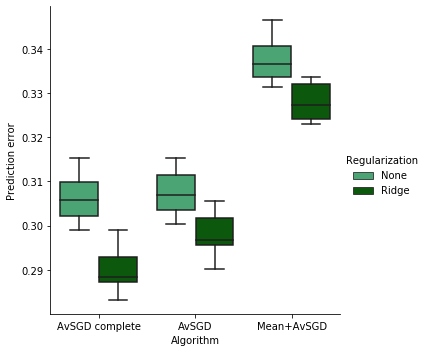

In [9]:
import seaborn as sns
resultPred=pd.DataFrame()
resultPred["Prediction error"]=list_sgd_av_comp+list_sgd_av+list_mean+list_sgd_av_comp_st+list_sgd_av_st+list_mean_st 
resultPred["Algorithm"]=['AvSGD complete']*Nbsim+['AvSGD']*Nbsim+['Mean+AvSGD']*Nbsim+['AvSGD complete']*Nbsim+['AvSGD']*Nbsim+['Mean+AvSGD']*Nbsim 
resultPred["Regularization"]=["None"]*Nbsim*3 +['Ridge']*Nbsim*3

my_pal= {"None": "mediumseagreen", "Ridge": "darkgreen"}
sns.catplot(x="Algorithm", y="Prediction error", kind="box",palette=my_pal, data=resultPred,hue="Regularization")
;